In [1]:
import matplotlib.pyplot as plt
import os
import wfdb
import glob
import random
import warnings
import tempfile
import shutil

from scipy.signal import butter, filtfilt

import numpy as np

from sklearn.preprocessing import MinMaxScaler

FOLDER_PATH = '../24h-emgcg/'
FOLDER_SAMPLE = '../24h-ecg-sample/'
FOLDER_NORMALIZE = '../24h-ecg-normalized/'
FOLDER_FILTER = '../24h-ecg-normalized-filter/'
DATASET_QC = "../dataset-qc-model/"
DATASET_QC_TEST = "../dataset-qc-test/"
LABEL_FILE = "label.txt"

In [2]:
line_counts = {
    "0 -> 10k": 0,
    "10k -> 100k": 0,
    "100k -> 1M": 0,
    "1M -> 25M": 0,
    "25M -> 50M": 0,
    ">50M": 0,
}

# Count files
for file_name in os.listdir(FOLDER_PATH):
    if file_name.endswith('_p_signal.txt'):
        file_path = os.path.join(FOLDER_PATH, file_name)
        with open(file_path, 'r') as f:
            line_count = sum(1 for line in f)

            # Categorize line counts
            if line_count <= 10000:
                line_counts["0 -> 10k"] += 1
            elif line_count <= 100000:
                line_counts["10k -> 100k"] += 1
            elif line_count <= 1000000:
                line_counts["100k -> 1M"] += 1
            elif line_count <= 25000000:
                line_counts["1M -> 25M"] += 1
            elif line_count <= 50000000:
                line_counts["25M -> 50M"] += 1
            elif line_count <= 90000000:
                line_counts[">50M"] += 1

for range_key, count in line_counts.items():
    print(f"{range_key}: {count} files")


0 -> 10k: 5 files
10k -> 100k: 17 files
100k -> 1M: 5 files
1M -> 25M: 14 files
25M -> 50M: 116 files
>50M: 48 files


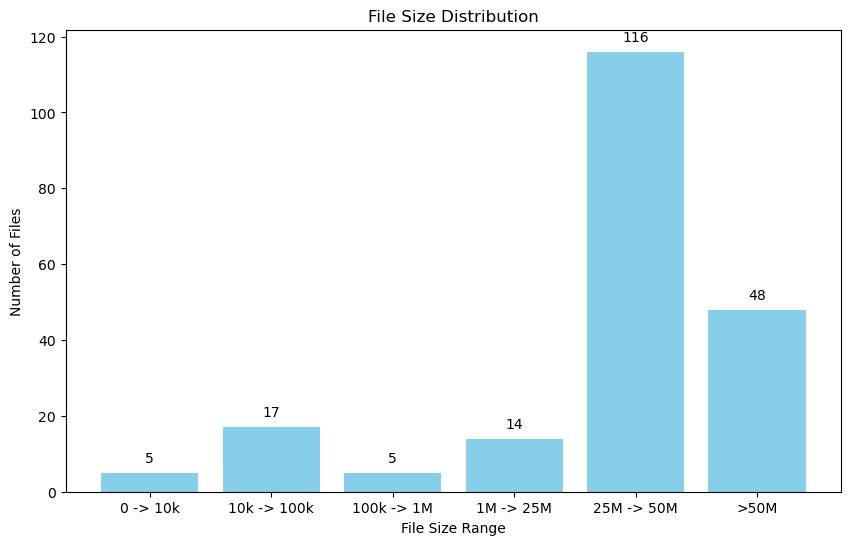

In [3]:
categories = ['0 -> 10k', '10k -> 100k', '100k -> 1M', '1M -> 25M', '25M -> 50M', '>50M']
values = [5, 17, 5, 14, 116, 48]

plt.figure(figsize=(10, 6))
plt.bar(categories, values, color='skyblue')

plt.title('File Size Distribution')
plt.xlabel('File Size Range')
plt.ylabel('Number of Files')

for i, value in enumerate(values):
    plt.text(i, value + 2, str(value), ha='center', va='bottom')

plt.show()

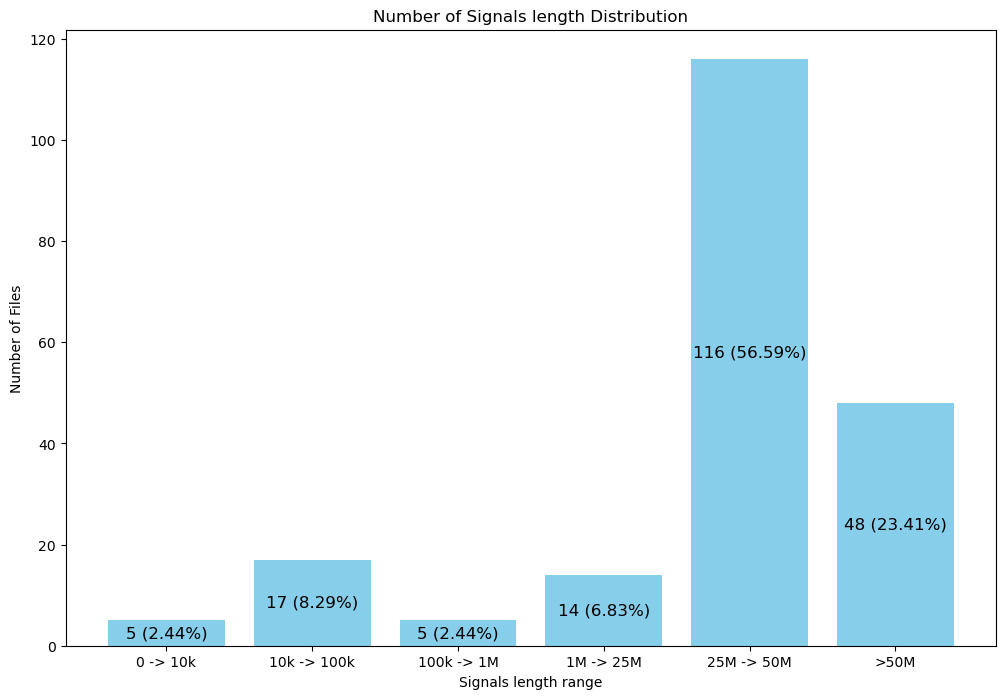

In [8]:
categories = ['0 -> 10k', '10k -> 100k', '100k -> 1M', '1M -> 25M', '25M -> 50M', '>50M']
values = [5, 17, 5, 14, 116, 48]

total_files = sum(values)
percentages = [value / total_files * 100 for value in values]

plt.figure(figsize=(12, 8))
bars = plt.bar(categories, values, color='skyblue')

plt.title('Number of Signal''s length Distribution')
plt.xlabel('Signal''s length range')
plt.ylabel('Number of Files')

for bar, value, percentage in zip(bars, values, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height / 2, f'{value} ({percentage:.2f}%)', ha='center', va='center', color='black', fontsize=12)

plt.show()

# CONVERT TO p_signal FILES USING 2 CHANNEL ecg_0 vs ecg_1

In [4]:
record_files = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.hea')]

records_missing_dat = []

records_exist = []

records_header_error = []

for record_file in record_files:
    record_name = os.path.splitext(record_file)[0]
    if not os.path.exists(os.path.join(FOLDER_PATH, f"{record_name}.dat")):
        records_missing_dat.append(record_name)
        continue  
    
    output_file_path = os.path.join(FOLDER_PATH, f"{record_name}_p_signal.txt")
    
    if os.path.exists(output_file_path):
        records_exist.append(record_file)
        continue  
    
    try:
        record = wfdb.rdrecord(os.path.join(FOLDER_PATH, record_name), channels=[0, 1])
    except Exception as e:
        if isinstance(e, FileNotFoundError):
            records_missing_dat.append(record_name)
        else:
            print(f"Error processing {record_name}: {str(e)}")
            records_header_error.append(record_name)
        continue
    
    signals = record.p_signal
    
    with open(output_file_path, 'w') as file:
        for signal in signals:
            file.write(f"{signal[0]}\t{signal[1]}\n")

print("Conversion completed.")
if records_missing_dat:
    print("The following records were skipped due to missing .dat files:")
    print(records_missing_dat)
if records_header_error:
    print("The following records had header syntax errors:")
    print(records_header_error)
print(f"Number of records converted: {len(record_files) - len(records_missing_dat) - len(records_header_error)}")

Conversion completed.
Number of records converted: 0


# DELETE ALL .dat .hea .maker files

In [5]:
extensions = ['.dat', '.hea', '.marker']

def delete_files_if_txt_exists(folder_path):
    for ext in extensions:
        file_pattern = os.path.join(folder_path, f'*{ext}')
        files = glob.glob(file_pattern)
        for file_path in files:
            base_name = os.path.splitext(os.path.basename(file_path))[0]
            txt_file_path = os.path.join(folder_path, f'{base_name}_p_signal.txt')
            if os.path.exists(txt_file_path):
                try:
                    os.remove(file_path)
                    print(f"Deleted: {file_path}")
                except OSError as e:
                    print(f"Error: {file_path} - {e.strerror}")

delete_files_if_txt_exists(FOLDER_PATH)

# CONVERT SIGNAL FROM uV to mV 

In [ ]:

for filename in os.listdir(FOLDER_PATH):
    file_path = os.path.join(FOLDER_PATH, filename)
    if os.path.isfile(file_path):
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as temp_file:
            with open(file_path, 'r') as file:
                for line in file:
                    values = line.split()
                    modified_values = [str(float(value)/1000) for value in values]
                    temp_file.write('\t'.join(modified_values) + '\n')

        shutil.copy(temp_file.name, file_path)
        os.remove(temp_file.name)

print("All files have been modified.")

# Function get list of file names, plot data in range,...

In [9]:

# List file names from folder name
def get_main_names_of_files(x):
    file_names = os.listdir(x)
    main_names = [name.split('_p_signal.txt')[0] for name in file_names if name.endswith('_p_signal.txt')]
    return main_names

# PLOT SIGNAL IN RANGE(m , n) BY FILENAME
def plot_ecg_signal(main_name_of_file, folder_path, n, m=0):
    # start m end n
    file_path = os.path.join(folder_path, f'{main_name_of_file}_p_signal.txt')
    if not os.path.exists(file_path):
        print(f'File {file_path} does not exist.')
        return
    try:
        # Load the data with a maximum of n rows
        warnings.filterwarnings("ignore", message="Input line contained no data")
        total_data = np.loadtxt(file_path, max_rows=n)
        total_rows = total_data.shape[0]
        if m < 0 or n > total_rows or m >= n:
            raise ValueError(f"Invalid range: {m} to {n}. File contains {total_rows} rows.")
        data_segment = total_data[m:n, :]
    except Exception as e:
        print(f"Error reading the file: {e}")
        return
    time = np.arange(m, n) * 1  # 1 ms per sample
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, data_segment[:, 0])
    plt.title('Channel 1')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (mV)')
    plt.subplot(2, 1, 2)
    plt.plot(time, data_segment[:, 1])
    plt.title('Channel 2')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (mV)')
    
    plt.tight_layout()
    plt.show()

def count_rows_in_file(prefix, directory):
    suffix = '_p_signal.txt'
    filename = prefix + suffix
    file_path = os.path.join(directory, filename)
    
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            return len(lines)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

# names = get_main_names_of_files(FOLDER_PATH)

# print("Main names of files:", names)
# print(len(names))

# RAMDOMLY SAMPLE 100 NON-OVERLAPPING SEGMENTS EACH SIGNAL 

In [ ]:
sampling_rate = 1000  # Freq definition
segment_length_ms = 6000
segment_length_samples = int(sampling_rate * (segment_length_ms / 1000))

max_segments = 100

for filename in os.listdir(FOLDER_PATH):
    if filename.endswith('.txt') and 'p_signal' in filename:
        file_path = os.path.join(FOLDER_PATH, filename)
        output_base_filename = filename.replace('_p_signal.txt', '')

        with open(file_path, 'r') as file:
            data = file.readlines()

        # Maximum number of segments possible
        possible_segments = min(max_segments, len(data) // segment_length_samples)

        # Calculate start points for each segment
        start_indices = sorted(random.sample(range(0, len(data) - segment_length_samples + 1), possible_segments))

        for i, start in enumerate(start_indices):
            segment = data[start:start + int(segment_length_samples)]
            segment_filename = f"{output_base_filename}_{i + 1}_p_signal.txt"
            segment_file_path = os.path.join(FOLDER_SAMPLE, segment_filename)

            with open(segment_file_path, 'w') as outfile:
                outfile.writelines(segment)

        print(f"Processed {filename} into {possible_segments} segments.")

print("Sampling complete.")

Processed s0322-07052204_p_signal.txt into 100 segments.
Processed s0242-06012405_p_signal.txt into 100 segments.
Processed s0184-05091311_p_signal.txt into 100 segments.
Processed s0335-07040503_p_signal.txt into 100 segments.
Processed s0231-05111709_p_signal.txt into 100 segments.
Processed s0175-05030325_p_signal.txt into 100 segments.
Processed s0376-07091805_p_signal.txt into 100 segments.
Processed s0221-06082208_p_signal.txt into 2 segments.
Processed s0208-05102508_p_signal.txt into 100 segments.
Processed s0153-05021018_p_signal.txt into 100 segments.
Processed s0225-06022111_p_signal.txt into 100 segments.
Processed s0218-05110113_p_signal.txt into 100 segments.
Processed s0351-07062105_p_signal.txt into 100 segments.
Processed s0230-06013111_p_signal.txt into 100 segments.
Processed s0197-05060906_p_signal.txt into 100 segments.
Processed s0358-07071203_p_signal.txt into 100 segments.
Processed s0358-07071204_p_signal.txt into 100 segments.
Processed s0247-06050205_p_signal

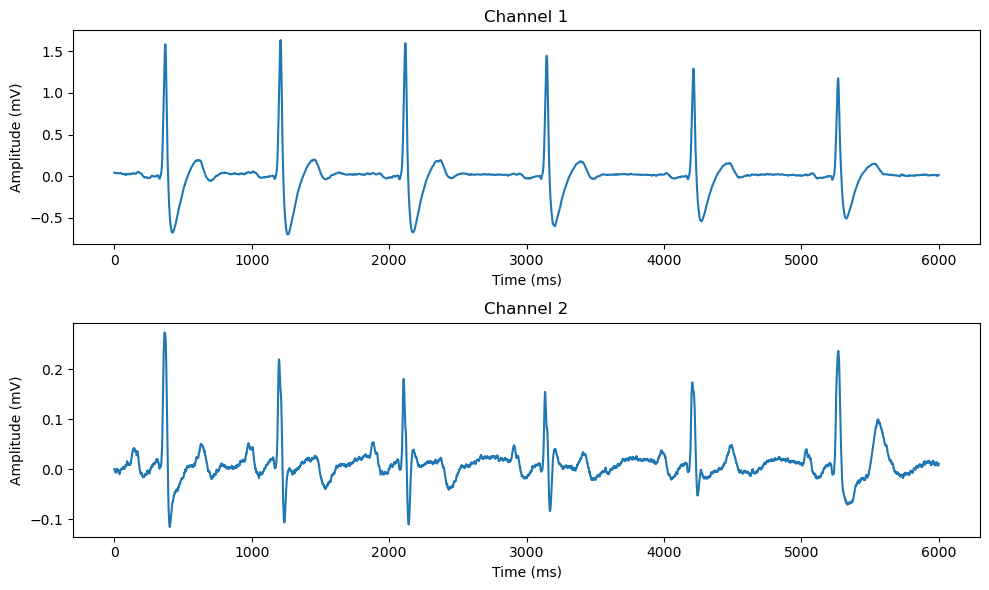

In [11]:
# CHECK DATA BY PLOT SIGNAL

# plot_ecg_signal('s0402', FOLDER_SAMPLE, 40000, 34000)
plot_ecg_signal('s0402-08010704_4', FOLDER_SAMPLE, 6000)
# plot_ecg_signal('s0402-08010704', FOLDER_PATH, 50000000)

# Normalizing datas after sampling using MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

for filename in os.listdir(FOLDER_SAMPLE):
    if filename.endswith('.txt'):
        file_path = os.path.join(FOLDER_SAMPLE, filename)
        
        # Load the data from the file
        data = np.loadtxt(file_path)

        # Check if the data is in two columns or a single column
        if data.ndim == 1:
            # If it's a single column, reshape for the scaler
            data = data.reshape(-1, 1)

        # Apply the MinMaxScaler to the data
        normalized_data = scaler.fit_transform(data)
        
        dest_file_path = os.path.join(FOLDER_NORMALIZE, filename)
        np.savetxt(dest_file_path, normalized_data)

print("All files have been normalized.")

All files have been normalized.


# Smoothing datas after normalization by ButterWorth filter to folder FOLDER_FILTER

In [18]:
def extract_columns(file_name):
    full_file_path = os.path.join(FOLDER_NORMALIZE, file_name)
    
    data = np.loadtxt(full_file_path)
    
    left = data[:, 0]
    return left

def compute(smooth):
    first_derivative = np.gradient(smooth, 10)
    second_derivative = np.gradient(first_derivative, 10)
    return first_derivative, second_derivative

# Function to apply the low-pass filter
def butterworth_filter(signal):
    cutoff_frequency = 11  # Cutoff frequency in Hz
    sampling_rate = 1000  # Sampling rate in Hz
    order = 2  # Order of the polynomial
    # divide by (0.5 * sampling_rate)
    # frequencies are often normalized by the Nyquist frequency
    # which is half the sampling rate. 
    # The Nyquist frequency is the highest frequency that can be effectively 
    # sampled without introducing aliasing according to the Nyquist-Shannon sampling theorem.
    b, a = butter(order, cutoff_frequency / (0.5 * sampling_rate), btype='low')
    return filtfilt(b, a, signal)

In [ ]:
for filename in os.listdir(FOLDER_NORMALIZE):
    if filename.endswith('p_signal.txt'):
        destination_file_path = os.path.join(FOLDER_FILTER, filename)
        
        data = extract_columns(filename)
        smoothed = butterworth_filter(data)
        hi_freq = data - smoothed
        first_der, second_der = compute(smoothed)
        
        # Write the smoothed data, high-frequency data, and derivatives to a new file
        with open(destination_file_path, 'w') as file:
            for i in range(len(data)):
                file.write(f"{data[i]}\t{smoothed[i]}\t{hi_freq[i]}\t{first_der[i]}\t{second_der[i]}\n")

print("Filtering complete.")

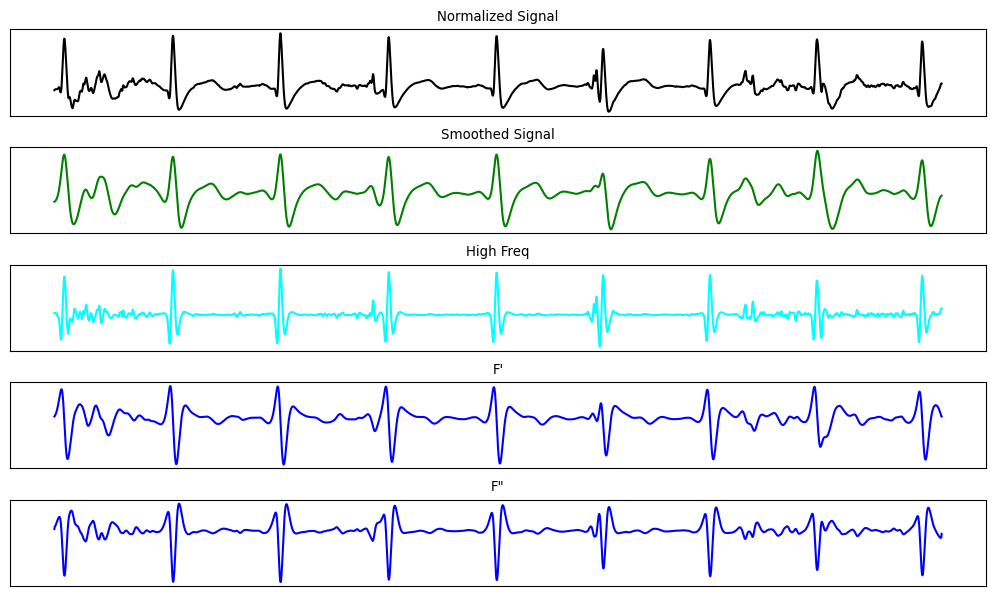

In [19]:
def plotpp(filename):
    data = extract_columns(filename)
    smoothed = butterworth_filter(data)
    hi_freq = data - smoothed
    first_der, second_der = compute(smoothed)
    colors = ['black', 'black', 'black', 'black', 'black']

    plt.figure(figsize=(10, 5)) 
    plt.rcParams.update({'font.size': 8})

    plt.subplot(5, 1, 1)
    plt.plot(data, color=colors[0])
    plt.title('normalized')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 2)
    plt.plot(smoothed, color=colors[1])
    plt.title('filtered')
    
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 3)
    plt.plot(hi_freq, color=colors[2])
    plt.title('hi freq')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 4)
    plt.plot(first_der, color=colors[3])
    plt.title('f\'')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 5)
    plt.plot(second_der, color=colors[4])
    plt.title('f\"')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.tight_layout()
    plt.show()

def plot_folder_file(folder, file_name):
    full_file_path = os.path.join(folder, file_name)
    
    data = np.loadtxt(full_file_path)
    
    raw = data[:, 0]
    smoothed = data[:, 1]
    hi_freq = data[:, 2]
    first_der = data[:, 3]
    second_der = data[:, 4]
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    plt.figure(figsize=(6, 6)) 
    plt.rcParams.update({'font.size': 8})

    plt.subplot(5, 1, 1)
    plt.plot(raw, color=colors[0])
    plt.title('Normalized Signal')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 2)
    plt.plot(smoothed, color=colors[1])
    plt.title('Smoothed Signal')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 3)
    plt.plot(hi_freq, color=colors[2])
    plt.title('High Freq')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 4)
    plt.plot(first_der, color=colors[3])
    plt.title('f\'')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 5)
    plt.plot(second_der, color=colors[4])
    plt.title('f\"')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.tight_layout()
    plt.show()
    
plotpp('s0030-04051907_15_p_signal.txt')


# Clone randomly 4 segments each subject for training 
# 797 segments collected

In [ ]:
with open(os.path.join(DATASET_QC, LABEL_FILE), 'w') as label:
    for name in names:
        file = [file for file in os.listdir(FOLDER_FILTER) if file.startswith(name)]
        count_clone = min(4, len(file))  
        files_to_copy = random.sample(file, count_clone)
        for file_name in files_to_copy:
            source_file_path = os.path.join(FOLDER_FILTER, file_name)
            destination_file_path = os.path.join(DATASET_QC, file_name)
            shutil.copyfile(source_file_path, destination_file_path)
            label.write(f"{file_name} 1.0\n")

# Function for paging and manual label

In [20]:
def label(file_name, folder):
    with open(os.path.join(folder, LABEL_FILE), 'r+') as label_file:
        lines = label_file.readlines()
        label_file.seek(0)
        for line in lines:
            if file_name in line:
                line = line.replace(" 1.0", " 0.0")
            label_file.write(line)
        label_file.truncate()
        
def revert(file_name, folder):
    with open(os.path.join(folder, LABEL_FILE), 'r+') as label_file:
        lines = label_file.readlines()
        label_file.seek(0)
        for line in lines:
            if file_name in line:
                line = line.replace(" 0.0", " 1.0")
            label_file.write(line)
        label_file.truncate()
        
def paging(data, page, page_size):
  if page <= 0 or page_size <= 0:
    return [] 

  start_index = (page - 1) * page_size
  end_index = start_index + page_size

  if end_index > len(data):
    end_index = len(data)

  return data[start_index:end_index]

dataset = get_main_names_of_files(DATASET_QC)
dataset.sort()
print(dataset)

data = paging(dataset, 1, 2)
print(data)

['s0030-04051907_15', 's0030-04051907_36', 's0030-04051907_53', 's0030-04051907_78', 's0030-04051908_26', 's0030-04051908_30', 's0030-04051908_35', 's0030-04051908_7', 's0044-05062806_26', 's0044-05062806_29', 's0044-05062806_35', 's0044-05062806_46', 's0044-05062807_13', 's0044-05062807_33', 's0044-05062807_56', 's0044-05062807_74', 's0064-05081805_15', 's0064-05081805_40', 's0064-05081805_89', 's0064-05081805_97', 's0064-05081806_26', 's0064-05081806_73', 's0064-05081806_88', 's0064-05081806_91', 's0067-05040508_34', 's0067-05040508_57', 's0067-05040508_64', 's0067-05040508_95', 's0067-05040509_2', 's0067-05040509_3', 's0067-05040509_6', 's0067-05040509_7', 's0067-05040510_25', 's0067-05040510_35', 's0067-05040510_50', 's0067-05040510_59', 's0067-05040511_47', 's0067-05040511_48', 's0067-05040511_82', 's0067-05040511_97', 's0068-05022417_100', 's0068-05022417_17', 's0068-05022417_18', 's0068-05022417_82', 's0068-05022418_15', 's0068-05022418_70', 's0068-05022418_82', 's0068-05022418_

# Get list signal by pagination and grid plot

s0172-05071906_51_p_signal.txt
s0277-06090703_96_p_signal.txt
s0352-07060703_27_p_signal.txt
s0221-06082206_3_p_signal.txt
s0331-07031504_36_p_signal.txt
s0321-07022206_90_p_signal.txt
s0335-07040503_7_p_signal.txt
s0352-07060703_20_p_signal.txt
s0239-06012607_63_p_signal.txt
s0210-05092012_12_p_signal.txt
s0371-07091105_94_p_signal.txt
s0044-05062806_35_p_signal.txt
s0221-06082206_4_p_signal.txt
s0363-07072604_51_p_signal.txt
s0184-05091310_56_p_signal.txt
s0378-07100403_1_p_signal.txt
s0321-07022206_97_p_signal.txt
s0218-05110113_94_p_signal.txt
s0340-07050204_51_p_signal.txt
s0248-06041808_17_p_signal.txt
s0334-07040303_42_p_signal.txt
s0153-05021019_5_p_signal.txt
s0160-04052807_76_p_signal.txt
s0331-07031503_13_p_signal.txt


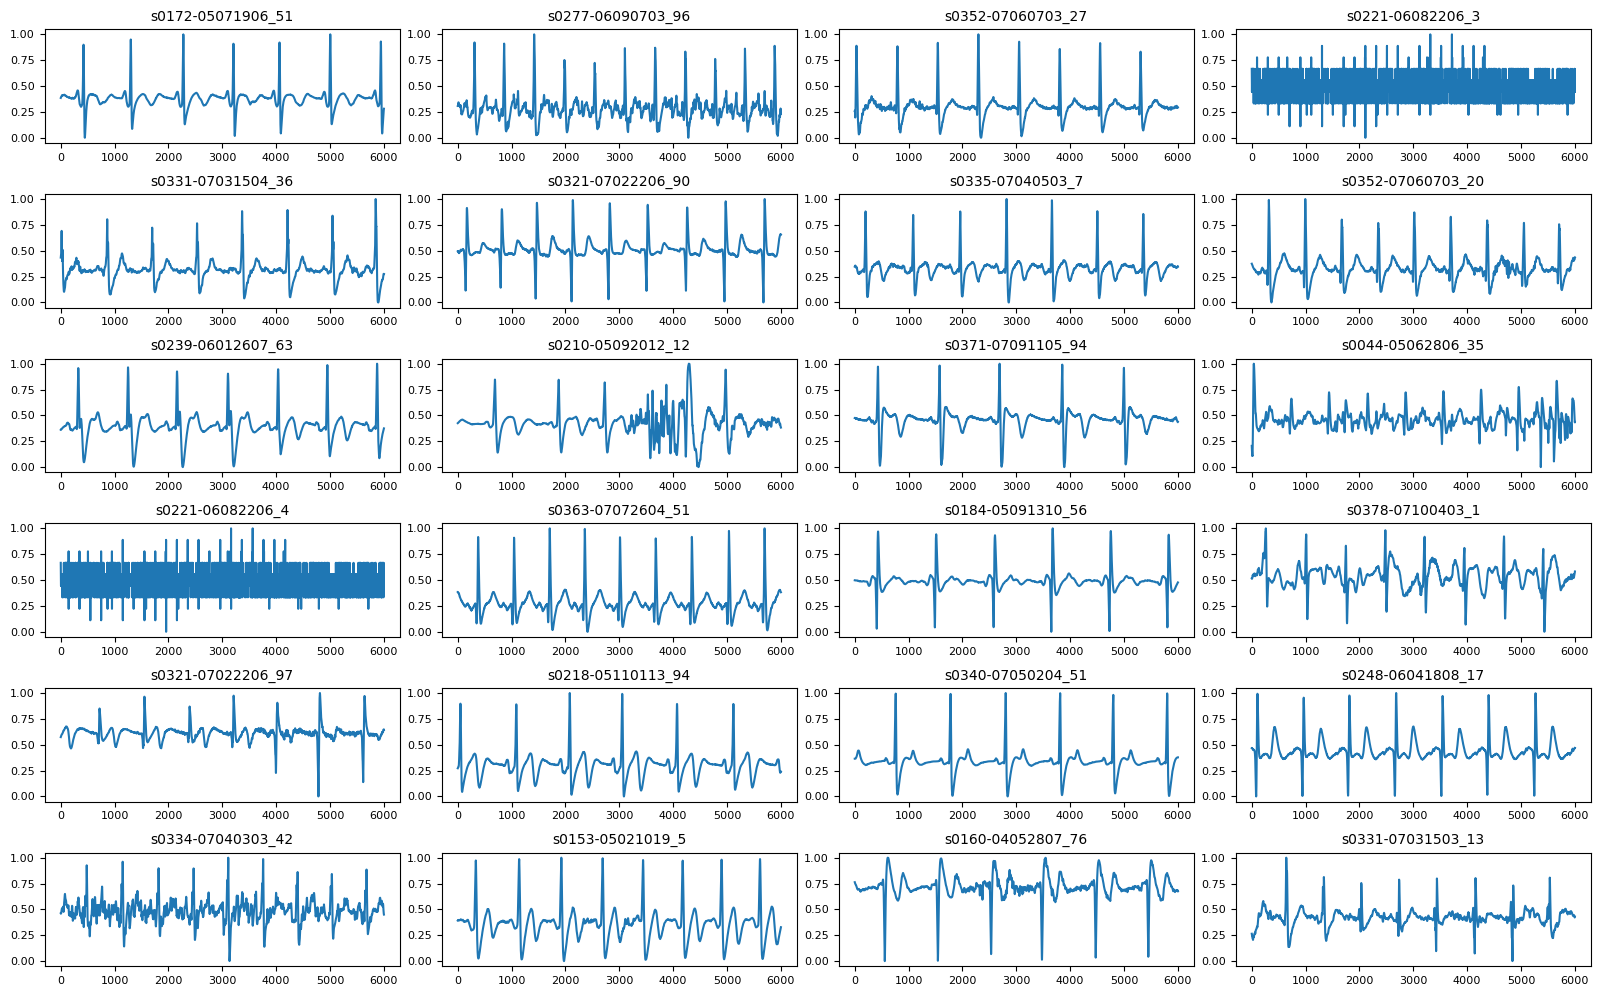

In [21]:
def grid_plot(folder, page, pageSize = 24, num_cols = 4):
    dataset = get_main_names_of_files(folder)
    file_names = paging(dataset, page, pageSize)

    num_plots = len(file_names)
    num_cols = num_cols
    num_rows = int(np.ceil(num_plots / num_cols))

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 10))

    for i, file_name in enumerate(file_names):
        print(f'{file_name}_p_signal.txt')
        title = file_name
        file_name = os.path.join(folder, f'{file_name}_p_signal.txt')
        
        row = i // num_cols
        col = i % num_cols
        data = np.loadtxt(file_name) 
        data = data[:,0]
        axs[row, col].plot(data)
        axs[row, col].set_title(title, size=10)
        
    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

grid_plot(DATASET_QC, 1, 24, 4)

# Check data drawn and call method label manually

In [ ]:
label('s0030-04051907_53_p_signal.txt', DATASET_QC)
label('s0044-05062806_26_p_signal.txt', DATASET_QC)
label('s0044-05062806_35_p_signal.txt', DATASET_QC)
label('s0064-05081805_40_p_signal.txt', DATASET_QC)
label('s0064-05081805_89_p_signal.txt', DATASET_QC)
label('s0064-05081806_88_p_signal.txt', DATASET_QC)
label('s0322-07052205_73_p_signal.txt', DATASET_QC)
label('s0322-07052205_78_p_signal.txt', DATASET_QC)
label('s0324-07030105_36_p_signal.txt', DATASET_QC)
label('s0354-07051506_51_p_signal.txt', DATASET_QC)
label('s0324-07030105_37_p_signal.txt', DATASET_QC)
label('s0334-07040303_42_p_signal.txt', DATASET_QC)
label('s0334-07040304_91_p_signal.txt', DATASET_QC)
label('s0336-07041701_11_p_signal.txt', DATASET_QC)
label('s0331-07031504_33_p_signal.txt', DATASET_QC)
label('s0336-07041701_12_p_signal.txt', DATASET_QC)
label('s0343-07080704_66_p_signal.txt', DATASET_QC)
label('s0348-07052403_33_p_signal.txt', DATASET_QC)
label('s0351-07062105_91_p_signal.txt', DATASET_QC)
label('s0343-07080704_54_p_signal.txt', DATASET_QC)
label('s0353-07060504_18_p_signal.txt', DATASET_QC)
label('s0352-07060702_12_p_signal.txt', DATASET_QC)
label('s0067-05040510_25_p_signal.txt', DATASET_QC)
label('s0067-05040510_35_p_signal.txt', DATASET_QC)
label('s0067-05040510_50_p_signal.txt', DATASET_QC)
label('s0067-05040510_59_p_signal.txt', DATASET_QC)
label('s0068-05022417_100_p_signal.tx', DATASET_QC)
label('s0068-05022417_18_p_signal.txt', DATASET_QC)
label('s0068-05022417_82_p_signal.txt', DATASET_QC)
label('s0068-05022418_15_p_signal.txt', DATASET_QC)
label('s0068-05022418_82_p_signal.txt', DATASET_QC)
label('s0121-04042801_71_p_signal.txt', DATASET_QC)
label('s0132-04102802_72_p_signal.txt', DATASET_QC)
label('s0153-05021018_100_p_signal.tx', DATASET_QC)
label('s0153-05021018_41_p_signal.txt', DATASET_QC)
label('s0154-05050307_72_p_signal.txt', DATASET_QC)
label('s0160-04052807_76_p_signal.txt', DATASET_QC)
label('s0160-04052808_13_p_signal.txt', DATASET_QC)
label('s0163-04060411_47_p_signal.txt', DATASET_QC)
label('s0163-04060411_49_p_signal.txt', DATASET_QC)
label('s0164-06033004_90_p_signal.txt', DATASET_QC)
label('s0164-06033107_75_p_signal.txt', DATASET_QC)
label('s0164-06033107_99_p_signal.txt', DATASET_QC)
label('s0165-05092209_95_p_signal.txt', DATASET_QC)
label('s0166-05031008_46_p_signal.txt', DATASET_QC)
label('s0166-05031009_29_p_signal.txt', DATASET_QC)
label('s0166-05031009_41_p_signal.txt', DATASET_QC)
label('s0174-05062111_37_p_signal.txt', DATASET_QC)
label('s0174-05062111_76_p_signal.txt', DATASET_QC)
label('s0174-05062111_93_p_signal.txt', DATASET_QC)
label('s0176-04060217_87_p_signal.txt', DATASET_QC)
label('s0178-05041205_86_p_signal.txt', DATASET_QC)
label('s0184-05091310_82_p_signal.txt', DATASET_QC)
label('s0184-05091311_13_p_signal.txt', DATASET_QC)
label('s0194-05071408_65_p_signal.txt', DATASET_QC)
label('s0197-05060905_16_p_signal.txt', DATASET_QC)
label('s0197-05060905_21_p_signal.txt', DATASET_QC)
label('s0199-05041912_97_p_signal.txt', DATASET_QC)
label('s0199-05041913_37_p_signal.txt', DATASET_QC)
label('s0207-05090822_10_p_signal.txt', DATASET_QC)
label('s0210-05092012_12_p_signal.txt', DATASET_QC)
label('s0212-05111011_22_p_signal.txt', DATASET_QC)
label('s0213-05092707_64_p_signal.txt', DATASET_QC)
label('s0218-05110112_58_p_signal.txt', DATASET_QC)
label('s0322-07052204_21_p_signal.txt', DATASET_QC)
label('s0322-07052204_22_p_signal.txt', DATASET_QC)
label('s0322-07052204_31_p_signal.txt', DATASET_QC)
label('s0322-07052204_54_p_signal.txt', DATASET_QC)
label('s0322-07052205_20_p_signal.txt', DATASET_QC)
label('s0364-07072403_83_p_signal.txt', DATASET_QC)
label('s0221-06082210_74_p_signal.txt', DATASET_QC)
label('s0221-06082210_75_p_signal.txt', DATASET_QC)
label('s0221-06082209_96_p_signal.txt', DATASET_QC)
label('s0227-06020209_85_p_signal.txt', DATASET_QC)
label('s0230-06013110_22_p_signal.txt', DATASET_QC)
label('s0230-06013110_52_p_signal.txt', DATASET_QC)
label('s0230-06013110_91_p_signal.txt', DATASET_QC)
label('s0230-06013111_40_p_signal.txt', DATASET_QC)
label('s0230-06013111_43_p_signal.txt', DATASET_QC)
label('s0230-06013111_72_p_signal.txt', DATASET_QC)
label('s0230-06013111_84_p_signal.txt', DATASET_QC)
label('s0231-05111708_52_p_signal.txt', DATASET_QC)
label('s0231-05111708_90_p_signal.txt', DATASET_QC)
label('s0239-06012608_18_p_signal.txt', DATASET_QC)
label('s0240-06030215_14_p_signal.txt', DATASET_QC)
label('s0240-06030216_59_p_signal.txt', DATASET_QC)
label('s0374-07092706_44_p_signal.txt', DATASET_QC)
label('s0376-07091804_78_p_signal.txt', DATASET_QC)
label('s0380-07100203_90_p_signal.txt', DATASET_QC)
label('s0399-07120404_90_p_signal.txt', DATASET_QC)
label('s0248-06041807_10_p_signal.txt', DATASET_QC)
label('s0248-06041807_15_p_signal.txt', DATASET_QC)
label('s0248-06041807_30_p_signal.txt', DATASET_QC)
label('s0248-06041808_16_p_signal.txt', DATASET_QC)
label('s0277-06090703_21_p_signal.txt', DATASET_QC)
label('s0305-06113003_74_p_signal.txt', DATASET_QC)
label('s0321-07022201_12_p_signal.txt', DATASET_QC)
label('s0176-04060217_3_p_signal.txt', DATASET_QC)
label('s0207-05090822_9_p_signal.txt', DATASET_QC)
label('s0176-04060217_3_p_signal.txt', DATASET_QC)
label('s0221-06082202_1_p_signal.txt', DATASET_QC)
label('s0221-06082203_1_p_signal.txt', DATASET_QC)
label('s0221-06082204_1_p_signal.txt', DATASET_QC)
label('s0221-06082205_1_p_signal.txt', DATASET_QC)
label('s0221-06082205_2_p_signal.txt', DATASET_QC)
label('s0221-06082205_3_p_signal.txt', DATASET_QC)
label('s0221-06082206_2_p_signal.txt', DATASET_QC)
label('s0221-06082206_3_p_signal.txt', DATASET_QC)
label('s0221-06082206_4_p_signal.txt', DATASET_QC)
label('s0221-06082206_5_p_signal.txt', DATASET_QC)
label('s0225-06022111_4_p_signal.txt', DATASET_QC)
label('s0230-06013110_5_p_signal.txt', DATASET_QC)
label('s0247-06050206_1_p_signal.txt', DATASET_QC)
label('s0247-06050206_2_p_signal.txt', DATASET_QC)
label('s0247-06050206_3_p_signal.txt', DATASET_QC)
label('s0247-06050206_4_p_signal.txt', DATASET_QC)
label('s0321-07022201_5_p_signal.txt', DATASET_QC)
label('s0321-07022202_4_p_signal.txt', DATASET_QC)
label('s0321-07022202_6_p_signal.txt', DATASET_QC)
label('s0322-07052205_7_p_signal.txt', DATASET_QC)
label('s0331-07031502_1_p_signal.txt', DATASET_QC)
label('s0331-07031502_2_p_signal.txt', DATASET_QC)
label('s0331-07031502_6_p_signal.txt', DATASET_QC)
label('s0331-07031502_8_p_signal.txt', DATASET_QC)
label('s0336-07041701_2_p_signal.txt', DATASET_QC)
label('s0336-07041701_6_p_signal.txt', DATASET_QC)
label('s0337-07032903_1_p_signal.txt', DATASET_QC)
label('s0337-07032903_2_p_signal.txt', DATASET_QC)
label('s0337-07032903_3_p_signal.txt', DATASET_QC)
label('s0352-07060702_2_p_signal.txt', DATASET_QC)
label('s0352-07060702_3_p_signal.txt', DATASET_QC)
label('s0352-07060702_5_p_signal.txt', DATASET_QC)
label('s0067-05040509_2_p_signal.txt', DATASET_QC)
label('s0067-05040509_3_p_signal.txt', DATASET_QC)
label('s0067-05040509_6_p_signal.txt', DATASET_QC)
label('s0067-05040509_7_p_signal.txt', DATASET_QC)
label('s0353-07060503_8_p_signal.txt', DATASET_QC)
label('s0353-07060504_2_p_signal.txt', DATASET_QC)
label('s0363-07072604_6_p_signal.txt', DATASET_QC)
label('s0371-07091104_8_p_signal.txt', DATASET_QC)